# Train a tree based model for regression task: predict delay difference

In [1]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import sklearn
# from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [2]:
import sys
import logging
import datetime

nblog = open("./logs/tree_pdp_shap_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
%%time

df_traffic = pd.read_csv('output/austin_2022_GP_10min_interval_delaydifference_with_features_forML_final.csv')
df_traffic = df_traffic.rename(columns={"miles": "segment_length"})

df_traffic['minutes_since_midnight'] = df_traffic['hour_min'].apply(lambda x: int(x[:2]) * 60 + int(x[3:]))
df_traffic = df_traffic[df_traffic['tmc_code']!='112+53808']  # this is a segment disconnected with every road

print(df_traffic.date.unique())
print('unique road segments (samples):',df_traffic.tmc_code.unique().shape[0])
print('total observations: ',df_traffic.shape[0])

# because the event usually begins in the morning after 10, people arrive typically around that time, so we want to only focus on after 930
df_traffic = df_traffic[df_traffic['minutes_since_midnight']>=540]
print(df_traffic.shape[0]) #866449
# df_traffic = pd.get_dummies(df_traffic, columns=['date'], prefix='date')

['2022-10-17' '2022-10-18' '2022-10-19' '2022-10-20' '2022-10-21'
 '2022-10-22' '2022-10-23']
unique road segments (samples): 3225
total observations:  3549832
2197949
CPU times: user 14.1 s, sys: 1.13 s, total: 15.2 s
Wall time: 15.6 s


## Merge with graph embeddings of road network

In [4]:
df_road_embeddings = pd.read_csv('output/network_embeddings.csv')
suffixes = [int(col.split('_')[-1]) for col in df_road_embeddings.columns if col.startswith('embedding_')]
max_embeddings = max(suffixes) if suffixes else None
print(max_embeddings)

df_traffic = df_traffic.merge(df_road_embeddings, how='left')
print(df_traffic.shape[0])
df_traffic.head(2)

,tmc_code,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63
0,112P13033,0.89394,-0.70949,0.27297,0.94302,0.52385,0.21081,0.19544,-1.11029,-0.34201,-0.63806,0.61514,0.08389,0.20198,-0.60907,-1.18846,0.40890,-1.35415,0.45196,-0.02265,0.01204,0.05474,-0.15486,-0.30685,-0.51994,-0.40198,1.02627,-0.30101,0.12434,-0.53349,-0.29412,0.40588,0.99231,-0.38362,0.02875,0.98902,0.53337,-0.69483,0.10666,0.00286,-0.30354,-0.18832,-0.04690,-0.95317,-0.48840,-0.55021,0.02758,-0.91661,-0.29719,-0.41314,0.79062,0.83682,-0.54500,-0.49934,-0.27126,0.14315,-0.27732,-0.00200,-0.43380,-0.55204,0.99135,-0.46165,0.90756,0.21971,0.69996
1,112+08908,0.95594,-0.09309,0.68374,-0.25662,-0.40958,-0.69403,0.24038,-1.07453,0.11010,0.91076,-1.29390,0.68600,-0.25977,-0.23630,0.42559,0.60496,-0.73102,0.16498,-0.40871,0.50723,0.37721,0.22079,-0.88531,-0.90539,-0.73308,0.01204,-0.34629,0.40196,-0.50550,0.43088,0.71081,0.12564,-0.62371,0.46146,-0.49235,0.65895,-0.00663,-0.31751,-0.02638,-0.31744,0.01322,0.17740,-0.23827,-0.04222,0.21908,0.81301,-0.56844,-0.80706,0.92946,0.32437,0.75485,-0.37074,-0.11247,-0.39159,1.35846,0.17667,0.02355,-1.27719,0.58497,0.47358,-0.55544,0.64552,-0.01274,0.70810
2,112+16538,0.20269,-0.16160,-0.02221,0.63865,0.49279,-1.34900,-0.63917,-0.18361,0.43124,0.21794,-0.23086,-0.05830,0.35884,-0.01433,0.49366,-0.13151,-1.23072,0.43204,-0.54838,0.91951,0.33172,-0.90362,-0.06825,-0.43013,-0.18407,-0.50543,-0.87509,-0.17228,0.29572,0.03202,0.30549,-0.68464,0.75256,0.16532,-0.38300,0.15605,-0.25988,-0.95127,0.00084,-0.62071,0.16747,0.59019,-0.39169,-0.94457,0.23689,0.17613,-0.63443,0.24737,-0.02575,0.37269,1.12009,0.04709,-1.14419,-0.95015,0.23540,-0.22203,-0.06967,-0.88440,0.36051,0.17107,-0.21150,0.79029,-0.67897,-0.21528
3,112+16539,0.29767,-0.12916,0.19061,0.39332,0.21330,-1.40112,-0.76361,-0.45503,0.50266,0.14276,-0.27168,-0.19807,0.22116,-0.01345,0.38678,-0.07689,-1.26219,0.48296,-0.76492,0.86878,0.28393,-0.82666,-0.34225,-0.60020,0.02567,-0.52546,-1.07706,-0.27753,0.39612,0.31638,0.16485,-0.89141,0.53073,-0.07369,-0.28220,0.35657,-0.20383,-0.70933,0.03901,-0.63679,0.27217,0.60702,-0.36990,-0.64900,0.21683,0.31047,-0.63086,0.31345,0.14252,0.46350,1.17986,0.29807,-1.20073,-1.01167,0.35681,-0.03589,0.02295,-0.70811,0.34485,-0.24115,-0.18240,0.73251,-0.38847,-0.12300
4,112P13038,0.79854,-0.14171,-0.31858,-0.20362,0.42861,-0.47819,-0.36354,-0.75137,-0.66852,-0.85108,-0.23962,-0.63189,-0.33982,-1.12653,-0.51921,0.38265,-1.29554,-0.24666,-0.06941,0.62835,0.29474,-0.62578,-0.51893,-1.17589,-0.54294,0.22384,-0.85091,0.00092,-0.86553,0.43220,0.50107,0.40156,0.14210,0.35354,-0.16715,0.43625,-0.12335,-0.04073,0.16821,-0.02090,0.15060,0.27620,-0.54163,-0.42673,-0.47866,-0.15578,-0.80727,-0.30686,-0.73352,-0.22047,0.26652,-0.38890,0.32571,-0.28149,-0.35489,0.35793,-0.16883,-0.91197,0.43637,0.79149,-0.59796,-0.16497,0.39537,0.49926


# Filtering data for ML

In [21]:
_param_day_of_week = 5 # 5: Saturday, 6: Sunday
_param_morning_or_evening = 'morning' # 'evening'
df_traffic = df_traffic[df_traffic['day_of_week']==_param_day_of_week]
print(df_traffic.shape[0])

# select two focused time period for training a ML model
if _param_morning_or_evening == 'morning':
    df_traffic = df_traffic[(df_traffic['minutes_since_midnight']>=10*60)&(df_traffic['minutes_since_midnight']<=12*60)] 
elif _param_morning_or_evening == 'evening':
    df_traffic = df_traffic[(df_traffic['minutes_since_midnight']>=17*60)&(df_traffic['minutes_since_midnight']<=20*60)] 
print(df_traffic.shape[0])

290070
41899


# Descriptive statistics (optional)

In [12]:
df_traffic.columns

Index(['tmc_code', 'hour_min', 'delay_baseline', 'delay_focus', 'delay_difference', 'date', 'intersection', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'segment_length', 'airbnb_count', 'distance_to_venue_centroid', 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 'distance_to_Shuttle_Expo_Center', 'segment_bearing', 'osm_id', 'road_type', 'oneway', 'lanes_mean', 'maxspeed_value', 'day_of_week', 'no_devices', 'no_devices_baseline', 'no_devices_focus', 'demand_diff', 'minutes_since_midnight', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 'embedding_13', 'embedding_14', 'embedding_15', 'embedding_16', 'embedding_17', 'embedding_18', 'embedding_19', 'embedding_20', 'embedding_21', 'embedding_22', 'embedding_23', 'embedding_24', 'embedding_25', 'embedding_26', 'embedding_27',
       '

In [10]:
# df_traffic.max_speed.describe().apply(lambda x: f"{x:.2f}")
# df_traffic.segment_bearing.describe()

In [11]:
# df_traffic['road_type'].value_counts(normalize=True).apply(lambda x: f"{x*100:.2f}").sort_index(ascending=True)

# Preparing training data

In [22]:
# df_test = df_traffic[['minutes_since_midnight',   'segment_length',
#                 'date_2022-10-21', 'date_2022-10-22', 'date_2022-10-23',
#                 'airbnb_count',  'distance_to_venue_centroid', 'oneway', 'lanes_mean','road_type',
#             'distance_to_Shuttle_Waterloo_Park', 
#                ]].copy() 
# df_test_cor = df_test.corr()
# pd.DataFrame(np.linalg.inv(df_test.corr().values), index = df_test_cor.index, columns=df_test_cor.columns)

feature_names = ['minutes_since_midnight', 'segment_length','segment_bearing', 'oneway', 'lanes_mean','road_type', 'maxspeed_value',
                'day_of_week', 'airbnb_count', 'distance_to_venue_centroid', 'no_devices_baseline', 'no_devices_focus'
               ] #'no_devices'

feature_names.extend([f"embedding_{i}" for i in range(max_embeddings)])

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare input features and labels for the model

X = df_traffic[feature_names].copy() 
# 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 'distance_to_Shuttle_Expo_Center',
# 'start_latitude', 'start_longitude',

X['road_type'] = X['road_type'].astype('category')

y = df_traffic['delay_difference'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Total sample size:', X.shape[0])
print('Total training set size:', X_train.shape[0])
print('Total test set size:', X_test.shape[0])

Total sample size: 41899
Total training set size: 29329
Total test set size: 12570


In [20]:
# %%time
# # check VIF
# df_cor = X.corr()
# pd.DataFrame(np.linalg.inv(X.corr().values), index = df_cor.index, columns=df_cor.columns)

# Hyperparameter tuning using optuna

In [ ]:
%%time
## this step took 25min to finish

import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from lightgbm import LGBMRegressor

def objective(trial):
    # Define hyperparameters to optimize
    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 1e-1, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "verbosity": -1,  # Suppress LightGBM logs
    }
    
    
    # Initialize LGBMRegressor with the suggested hyperparameters
    model = LGBMRegressor(**params, categorical_feature=['road_type'])
    
    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    rmse_scorer = make_scorer(mean_squared_error, squared=False)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=rmse_scorer)
    # scores = cross_val_score(model, X_test, y_test, cv=kf, scoring=rmse_scorer)

    return scores.mean()

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)

[I 2025-02-12 18:48:06,362] A new study created in memory with name: no-name-8cc75767-3678-46b7-9b78-c1d074a68f88


[LightGBM] [Warning] feature_fraction is set=0.695054103194183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.695054103194183
[LightGBM] [Warning] lambda_l1 is set=4.293012553124642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.293012553124642
[LightGBM] [Warning] bagging_fraction is set=0.6297734715331711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6297734715331711
[LightGBM] [Warning] lambda_l2 is set=8.741805090279122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.741805090279122
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.695054103194183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.695054103194183
[LightGBM] [Warning] lambda_l1 is set=4.293012553124642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.293012553124642
[LightGBM] [Warning] bagging_fraction is set=0.

[I 2025-02-12 18:48:11,052] Trial 0 finished with value: 12.904960300927081 and parameters: {'num_leaves': 75, 'max_depth': 6, 'learning_rate': 0.031021781351166938, 'n_estimators': 147, 'min_child_samples': 45, 'min_child_weight': 0.0011888561815673999, 'lambda_l1': 4.293012553124642, 'lambda_l2': 8.741805090279122, 'feature_fraction': 0.695054103194183, 'bagging_fraction': 0.6297734715331711, 'bagging_freq': 2}. Best is trial 0 with value: 12.904960300927081.


[LightGBM] [Warning] feature_fraction is set=0.7466612994711719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7466612994711719
[LightGBM] [Warning] lambda_l1 is set=1.4241433283758331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4241433283758331
[LightGBM] [Warning] bagging_fraction is set=0.7611925685382479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7611925685382479
[LightGBM] [Warning] lambda_l2 is set=2.008722434903553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.008722434903553
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7466612994711719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7466612994711719
[LightGBM] [Warning] lambda_l1 is set=1.4241433283758331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4241433283758331
[LightGBM] [Warning] bagging_fraction i

[I 2025-02-12 18:49:13,063] Trial 1 finished with value: 11.369055759573458 and parameters: {'num_leaves': 184, 'max_depth': 18, 'learning_rate': 0.06391010100152723, 'n_estimators': 449, 'min_child_samples': 73, 'min_child_weight': 0.0010235695499607308, 'lambda_l1': 1.4241433283758331, 'lambda_l2': 2.008722434903553, 'feature_fraction': 0.7466612994711719, 'bagging_fraction': 0.7611925685382479, 'bagging_freq': 3}. Best is trial 1 with value: 11.369055759573458.


[LightGBM] [Warning] feature_fraction is set=0.9948039996284082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9948039996284082
[LightGBM] [Warning] lambda_l1 is set=1.2906848213298783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2906848213298783
[LightGBM] [Warning] bagging_fraction is set=0.7659351402194134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659351402194134
[LightGBM] [Warning] lambda_l2 is set=7.940861824574965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.940861824574965
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9948039996284082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9948039996284082
[LightGBM] [Warning] lambda_l1 is set=1.2906848213298783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2906848213298783
[LightGBM] [Warning] bagging_fraction i

[I 2025-02-12 18:49:38,448] Trial 2 finished with value: 11.422977771337683 and parameters: {'num_leaves': 151, 'max_depth': 10, 'learning_rate': 0.059719722981562987, 'n_estimators': 420, 'min_child_samples': 47, 'min_child_weight': 0.001562933264311422, 'lambda_l1': 1.2906848213298783, 'lambda_l2': 7.940861824574965, 'feature_fraction': 0.9948039996284082, 'bagging_fraction': 0.7659351402194134, 'bagging_freq': 4}. Best is trial 1 with value: 11.369055759573458.


[LightGBM] [Warning] feature_fraction is set=0.7539566881295108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7539566881295108
[LightGBM] [Warning] lambda_l1 is set=8.35876322382051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.35876322382051
[LightGBM] [Warning] bagging_fraction is set=0.6743195753439098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6743195753439098
[LightGBM] [Warning] lambda_l2 is set=2.2603711912697477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2603711912697477
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7539566881295108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7539566881295108
[LightGBM] [Warning] lambda_l1 is set=8.35876322382051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.35876322382051
[LightGBM] [Warning] bagging_fraction is set=

[I 2025-02-12 18:50:03,662] Trial 3 finished with value: 11.654376196418143 and parameters: {'num_leaves': 127, 'max_depth': 10, 'learning_rate': 0.06513921551183824, 'n_estimators': 469, 'min_child_samples': 87, 'min_child_weight': 0.02306242977791182, 'lambda_l1': 8.35876322382051, 'lambda_l2': 2.2603711912697477, 'feature_fraction': 0.7539566881295108, 'bagging_fraction': 0.6743195753439098, 'bagging_freq': 6}. Best is trial 1 with value: 11.369055759573458.


[LightGBM] [Warning] feature_fraction is set=0.7575865642605208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7575865642605208
[LightGBM] [Warning] lambda_l1 is set=9.064047872566807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.064047872566807
[LightGBM] [Warning] bagging_fraction is set=0.9592680859551777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9592680859551777
[LightGBM] [Warning] lambda_l2 is set=1.2046921993726956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2046921993726956
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7575865642605208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7575865642605208
[LightGBM] [Warning] lambda_l1 is set=9.064047872566807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.064047872566807
[LightGBM] [Warning] bagging_fraction is 

[I 2025-02-12 18:50:16,892] Trial 4 finished with value: 11.555149062927429 and parameters: {'num_leaves': 120, 'max_depth': 5, 'learning_rate': 0.12081465303732045, 'n_estimators': 494, 'min_child_samples': 44, 'min_child_weight': 0.001052505051136479, 'lambda_l1': 9.064047872566807, 'lambda_l2': 1.2046921993726956, 'feature_fraction': 0.7575865642605208, 'bagging_fraction': 0.9592680859551777, 'bagging_freq': 3}. Best is trial 1 with value: 11.369055759573458.


[LightGBM] [Warning] feature_fraction is set=0.7357576570334996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7357576570334996
[LightGBM] [Warning] lambda_l1 is set=2.1879032567166288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1879032567166288
[LightGBM] [Warning] bagging_fraction is set=0.6174936531285314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6174936531285314
[LightGBM] [Warning] lambda_l2 is set=4.505730793333491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.505730793333491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7357576570334996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7357576570334996
[LightGBM] [Warning] lambda_l1 is set=2.1879032567166288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1879032567166288
[LightGBM] [Warning] bagging_fraction i

[I 2025-02-12 18:50:50,726] Trial 5 finished with value: 11.703692511774829 and parameters: {'num_leaves': 73, 'max_depth': 17, 'learning_rate': 0.04842112172516301, 'n_estimators': 377, 'min_child_samples': 56, 'min_child_weight': 0.00940037453277696, 'lambda_l1': 2.1879032567166288, 'lambda_l2': 4.505730793333491, 'feature_fraction': 0.7357576570334996, 'bagging_fraction': 0.6174936531285314, 'bagging_freq': 1}. Best is trial 1 with value: 11.369055759573458.


[LightGBM] [Warning] feature_fraction is set=0.7314243382099036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7314243382099036
[LightGBM] [Warning] lambda_l1 is set=1.6250006991228927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6250006991228927
[LightGBM] [Warning] bagging_fraction is set=0.8858151733795603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8858151733795603
[LightGBM] [Warning] lambda_l2 is set=2.605656019975555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.605656019975555
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7314243382099036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7314243382099036
[LightGBM] [Warning] lambda_l1 is set=1.6250006991228927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6250006991228927
[LightGBM] [Warning] bagging_fraction i

[I 2025-02-12 18:51:26,081] Trial 6 finished with value: 11.413930264058587 and parameters: {'num_leaves': 135, 'max_depth': 19, 'learning_rate': 0.08723254532353354, 'n_estimators': 294, 'min_child_samples': 98, 'min_child_weight': 0.02983895414215695, 'lambda_l1': 1.6250006991228927, 'lambda_l2': 2.605656019975555, 'feature_fraction': 0.7314243382099036, 'bagging_fraction': 0.8858151733795603, 'bagging_freq': 4}. Best is trial 1 with value: 11.369055759573458.


[LightGBM] [Warning] feature_fraction is set=0.6688705910142656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6688705910142656
[LightGBM] [Warning] lambda_l1 is set=5.7957633171415965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7957633171415965
[LightGBM] [Warning] bagging_fraction is set=0.7486151923848136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7486151923848136
[LightGBM] [Warning] lambda_l2 is set=4.528085663954049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.528085663954049
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6688705910142656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6688705910142656
[LightGBM] [Warning] lambda_l1 is set=5.7957633171415965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7957633171415965
[LightGBM] [Warning] bagging_fraction i

[I 2025-02-12 18:51:32,923] Trial 7 finished with value: 12.851633973684752 and parameters: {'num_leaves': 134, 'max_depth': 6, 'learning_rate': 0.029062266063294012, 'n_estimators': 207, 'min_child_samples': 93, 'min_child_weight': 0.09849454542002974, 'lambda_l1': 5.7957633171415965, 'lambda_l2': 4.528085663954049, 'feature_fraction': 0.6688705910142656, 'bagging_fraction': 0.7486151923848136, 'bagging_freq': 1}. Best is trial 1 with value: 11.369055759573458.


[LightGBM] [Warning] feature_fraction is set=0.7537292236995585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7537292236995585
[LightGBM] [Warning] lambda_l1 is set=6.970163638646762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.970163638646762
[LightGBM] [Warning] bagging_fraction is set=0.6263786951869232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6263786951869232
[LightGBM] [Warning] lambda_l2 is set=9.66669389227587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.66669389227587
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7537292236995585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7537292236995585
[LightGBM] [Warning] lambda_l1 is set=6.970163638646762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.970163638646762
[LightGBM] [Warning] bagging_fraction is set=

[I 2025-02-12 18:52:10,032] Trial 8 finished with value: 12.379051047128595 and parameters: {'num_leaves': 123, 'max_depth': 15, 'learning_rate': 0.01833056819520974, 'n_estimators': 396, 'min_child_samples': 88, 'min_child_weight': 0.07242845172051286, 'lambda_l1': 6.970163638646762, 'lambda_l2': 9.66669389227587, 'feature_fraction': 0.7537292236995585, 'bagging_fraction': 0.6263786951869232, 'bagging_freq': 7}. Best is trial 1 with value: 11.369055759573458.


[LightGBM] [Warning] feature_fraction is set=0.7992412981891912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7992412981891912
[LightGBM] [Warning] lambda_l1 is set=6.0356050634573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0356050634573
[LightGBM] [Warning] bagging_fraction is set=0.7019591755631611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7019591755631611
[LightGBM] [Warning] lambda_l2 is set=0.7186363207020008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7186363207020008
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7992412981891912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7992412981891912
[LightGBM] [Warning] lambda_l1 is set=6.0356050634573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0356050634573
[LightGBM] [Warning] bagging_fraction is set=0.70

[I 2025-02-12 18:53:09,766] Trial 9 finished with value: 11.296782106628902 and parameters: {'num_leaves': 152, 'max_depth': 14, 'learning_rate': 0.11266539831377556, 'n_estimators': 477, 'min_child_samples': 36, 'min_child_weight': 0.07459345583697259, 'lambda_l1': 6.0356050634573, 'lambda_l2': 0.7186363207020008, 'feature_fraction': 0.7992412981891912, 'bagging_fraction': 0.7019591755631611, 'bagging_freq': 5}. Best is trial 9 with value: 11.296782106628902.


[LightGBM] [Warning] feature_fraction is set=0.8805444029554104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8805444029554104
[LightGBM] [Warning] lambda_l1 is set=4.0034624932493825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0034624932493825
[LightGBM] [Warning] bagging_fraction is set=0.8703770406009878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703770406009878
[LightGBM] [Warning] lambda_l2 is set=0.2118663128974525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2118663128974525
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8805444029554104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8805444029554104
[LightGBM] [Warning] lambda_l1 is set=4.0034624932493825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0034624932493825
[LightGBM] [Warning] bagging_fracti

[I 2025-02-12 18:53:20,665] Trial 10 finished with value: 11.21886267620767 and parameters: {'num_leaves': 23, 'max_depth': 13, 'learning_rate': 0.15811397083818596, 'n_estimators': 311, 'min_child_samples': 13, 'min_child_weight': 0.005321152880254477, 'lambda_l1': 4.0034624932493825, 'lambda_l2': 0.2118663128974525, 'feature_fraction': 0.8805444029554104, 'bagging_fraction': 0.8703770406009878, 'bagging_freq': 10}. Best is trial 10 with value: 11.21886267620767.


[LightGBM] [Warning] feature_fraction is set=0.9068694242501909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9068694242501909
[LightGBM] [Warning] lambda_l1 is set=3.8842526903493737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8842526903493737
[LightGBM] [Warning] bagging_fraction is set=0.8555928779858778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8555928779858778
[LightGBM] [Warning] lambda_l2 is set=0.47308316869087896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47308316869087896
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9068694242501909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9068694242501909
[LightGBM] [Warning] lambda_l1 is set=3.8842526903493737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8842526903493737
[LightGBM] [Warning] bagging_frac

[I 2025-02-12 18:53:30,992] Trial 11 finished with value: 11.21510722688158 and parameters: {'num_leaves': 23, 'max_depth': 13, 'learning_rate': 0.19399237955833135, 'n_estimators': 298, 'min_child_samples': 19, 'min_child_weight': 0.005532029358809022, 'lambda_l1': 3.8842526903493737, 'lambda_l2': 0.47308316869087896, 'feature_fraction': 0.9068694242501909, 'bagging_fraction': 0.8555928779858778, 'bagging_freq': 10}. Best is trial 11 with value: 11.21510722688158.


[LightGBM] [Warning] feature_fraction is set=0.9085254841084913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9085254841084913
[LightGBM] [Warning] lambda_l1 is set=3.9295653562830037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9295653562830037
[LightGBM] [Warning] bagging_fraction is set=0.85624492924198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85624492924198
[LightGBM] [Warning] lambda_l2 is set=0.3161415130580556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3161415130580556
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9085254841084913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9085254841084913
[LightGBM] [Warning] lambda_l1 is set=3.9295653562830037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9295653562830037
[LightGBM] [Warning] bagging_fraction i

[I 2025-02-12 18:53:40,717] Trial 12 finished with value: 11.36445020990076 and parameters: {'num_leaves': 20, 'max_depth': 13, 'learning_rate': 0.1975957279334905, 'n_estimators': 299, 'min_child_samples': 10, 'min_child_weight': 0.004687021027057824, 'lambda_l1': 3.9295653562830037, 'lambda_l2': 0.3161415130580556, 'feature_fraction': 0.9085254841084913, 'bagging_fraction': 0.85624492924198, 'bagging_freq': 10}. Best is trial 11 with value: 11.21510722688158.


[LightGBM] [Warning] feature_fraction is set=0.8825861383039235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8825861383039235
[LightGBM] [Warning] lambda_l1 is set=3.4305868230046364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4305868230046364
[LightGBM] [Warning] bagging_fraction is set=0.8598983524096413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8598983524096413
[LightGBM] [Warning] lambda_l2 is set=6.655084822161446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.655084822161446
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8825861383039235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8825861383039235
[LightGBM] [Warning] lambda_l1 is set=3.4305868230046364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4305868230046364
[LightGBM] [Warning] bagging_fraction

[I 2025-02-12 18:53:48,844] Trial 13 finished with value: 11.18312622132758 and parameters: {'num_leaves': 20, 'max_depth': 10, 'learning_rate': 0.19150296832273053, 'n_estimators': 249, 'min_child_samples': 10, 'min_child_weight': 0.003567767408732747, 'lambda_l1': 3.4305868230046364, 'lambda_l2': 6.655084822161446, 'feature_fraction': 0.8825861383039235, 'bagging_fraction': 0.8598983524096413, 'bagging_freq': 10}. Best is trial 13 with value: 11.18312622132758.


[LightGBM] [Warning] feature_fraction is set=0.8981825213313939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8981825213313939
[LightGBM] [Warning] lambda_l1 is set=2.988605369893732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.988605369893732
[LightGBM] [Warning] bagging_fraction is set=0.9624067176907232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9624067176907232
[LightGBM] [Warning] lambda_l2 is set=6.352870857880368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.352870857880368
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8981825213313939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8981825213313939
[LightGBM] [Warning] lambda_l1 is set=2.988605369893732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.988605369893732
[LightGBM] [Warning] bagging_fraction is se

# Training: LightGBM
https://lightgbm.readthedocs.io/en/latest/index.html

In [ ]:
%%time
import lightgbm as lgb
from lightgbm import LGBMRegressor

try:
    print('Best trial:', study.best_trial.params)
    print('Best RMSE:', study.best_trial.value)
    params = study.best_trial.params
except:
    print(datetime.datetime.now(),'************ Optuna did not finish ************')
    params = {'num_leaves': 146, 'max_depth': 14, 'learning_rate': 0.1079378345383069, 'n_estimators': 783, 'min_child_samples': 10, 'min_child_weight': 0.007044781994082239, 'lambda_l1': 2.99230789127849, 'lambda_l2': 1.8874291044879725, 'feature_fraction': 0.832262823205684, 'bagging_fraction': 0.9133527951715594, 'bagging_freq': 10}
    
model = LGBMRegressor(**params, categorical_feature=['road_type']) # this way of training model is for better incorporation with scikit-learn
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=50)

# this way of training model is inherent method in lightgbm pacakge
# model = lgb.train(
#     params,
#     train_data,
#     valid_sets=[test_data],
#     early_stopping_rounds=50
# )

In [15]:
import joblib

output_path = './output/day_' + str(_param_day_of_week) + _param_morning_or_evening + '_lightgbm_' + str(datetime.datetime.now()) + '.pkl'
joblib.dump(model, output_path)

'./output/lightgbm_model_2025-02-09 13:47:13.515701.pkl'

# Model evaluation

In [11]:
%%time 
import lightgbm as lgb
import joblib

# Load the model back

output_path = './output/lightgbm_model_xxx.pkl'
model = joblib.load(output_path)
print("Model loaded successfully!")
# print(model.feature_name_)

Model loaded successfully!
CPU times: user 838 ms, sys: 75.2 ms, total: 913 ms
Wall time: 3.75 s


In [31]:
%%time

import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(datetime.datetime.now(),'Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y_test, y_pred)
print(datetime.datetime.now(),'Best Model R-squared: %.3f' % r2) 
# 0.479

2025-02-12 18:47:59.864897 Best Model RMSE: 11.726
2025-02-12 18:47:59.866068 Best Model R-squared: 0.435
CPU times: user 2.74 s, sys: 114 ms, total: 2.85 s
Wall time: 114 ms


# SHAP

In [15]:
# import gc
# del df_traffic;gc.collect()

22

In [16]:
%%time
# 47min 25s
import shap

print(datetime.datetime.now(),'*************** Start running SHAP ***************')
explainer = shap.TreeExplainer(model)
shap_values = explainer(X) # this line takes very long time

2025-02-09 13:51:43.056763 *************** Start running SHAP ***************
CPU times: user 1d 8h 50min 10s, sys: 12.6 s, total: 1d 8h 50min 23s
Wall time: 2h 33min 11s


In [26]:
print(len(shap_values.values))
print(df_traffic.shape[0])

2197949
2197949


save shap values for each observation (this takes 1min)

In [27]:
%%time
shaplist = ['shap_'+i for i in X.columns]
df_shape_values = pd.DataFrame(shap_values.values, columns=shaplist)

df_shape_values['tmc_code'] = df_traffic['tmc_code'].values
df_shape_values['minutes_since_midnight'] = df_traffic['minutes_since_midnight'].values

first_column = df_shape_values.pop('tmc_code')
df_shape_values.insert(0, 'tmc_code', first_column)

current_date = datetime.datetime.now().strftime('%Y-%m-%d')
df_shape_values.to_csv(f'./output/shap_values_{current_date}.csv',sep=',',index=False)
df_shape_values.head()

CPU times: user 3min 47s, sys: 7.53 s, total: 3min 54s
Wall time: 3min 56s


,tmc_code,shap_minutes_since_midnight,shap_segment_length,shap_segment_bearing,shap_oneway,shap_lanes_mean,shap_road_type,shap_maxspeed_value,shap_day_of_week,shap_airbnb_count,shap_distance_to_venue_centroid,shap_no_devices_baseline,shap_no_devices_focus,shap_embedding_0,shap_embedding_1,shap_embedding_2,shap_embedding_3,shap_embedding_4,shap_embedding_5,shap_embedding_6,shap_embedding_7,shap_embedding_8,shap_embedding_9,shap_embedding_10,shap_embedding_11,shap_embedding_12,shap_embedding_13,shap_embedding_14,shap_embedding_15,shap_embedding_16,shap_embedding_17,shap_embedding_18,shap_embedding_19,shap_embedding_20,shap_embedding_21,shap_embedding_22,shap_embedding_23,shap_embedding_24,shap_embedding_25,shap_embedding_26,shap_embedding_27,shap_embedding_28,shap_embedding_29,shap_embedding_30,shap_embedding_31,shap_embedding_32,shap_embedding_33,shap_embedding_34,shap_embedding_35,shap_embedding_36,shap_embedding_37,shap_embedding_38,shap_embedding_39,shap_embedding_40,shap_embedding_41,shap_embedding_42,shap_embedding_43,shap_embedding_44,shap_embedding_45,shap_embedding_46,shap_embedding_47,shap_embedding_48,shap_embedding_49,shap_embedding_50,shap_embedding_51,shap_embedding_52,shap_embedding_53,shap_embedding_54,shap_embedding_55,shap_embedding_56,shap_embedding_57,shap_embedding_58,shap_embedding_59,shap_embedding_60,shap_embedding_61,shap_embedding_62,minutes_since_midnight
0,112+04760,0.85047,-0.83042,0.02321,0.00634,-0.02718,0.01598,0.02026,0.82380,0.00524,-0.03174,-0.08993,0.12741,-0.02116,-0.00468,-0.02444,0.02564,-0.01838,0.01337,0.00946,0.05972,-0.02430,-0.00504,0.11789,-0.00338,0.00179,0.08614,-0.00751,-0.01203,-0.02824,-0.01533,-0.00516,0.00563,-0.00281,0.00386,0.03562,-0.01521,-0.02181,-0.00401,-0.00825,0.01187,0.04950,0.02633,-0.02737,0.05940,0.07825,0.05340,0.25925,-0.20347,-0.00641,0.05016,0.09583,0.04099,0.00696,0.04519,-0.04748,0.02073,0.02009,0.02502,0.03823,-0.01982,-0.00811,-0.01494,-0.02276,0.03322,0.01585,-0.03499,-0.01850,0.00686,-0.00827,0.00142,0.09414,0.00394,-0.01219,0.06129,0.09182,540
1,112+04760,0.88732,-0.82587,0.02440,0.00595,-0.03005,0.03099,0.01680,0.87011,0.01873,-0.02178,-0.18890,-0.13884,-0.02562,-0.02360,-0.02258,0.01503,-0.02210,0.01268,0.00854,0.05475,-0.01659,-0.00232,0.12188,0.00012,-0.00740,0.08601,-0.00465,-0.00608,-0.03655,0.01592,-0.00525,0.00740,-0.02621,0.00478,-0.06370,-0.00484,-0.01950,0.02221,-0.01415,0.00932,0.06835,0.02137,-0.02698,0.06014,0.04274,0.05673,0.25454,-0.07131,-0.00200,0.05242,0.09729,0.02941,0.00156,0.04476,-0.04998,0.03219,0.02686,0.03109,0.03233,-0.02358,-0.02238,-0.01535,-0.02185,0.02383,0.01982,-0.03425,-0.01890,0.00521,0.07713,0.00355,0.08686,0.00250,-0.01027,0.07258,0.09788,540
2,112+04760,0.68528,-0.25022,0.01319,0.00759,-0.02435,-0.00783,0.02016,0.61354,-0.00336,-0.03204,0.07891,0.11992,-0.02276,-0.00528,-0.03229,0.02231,-0.01938,0.01305,0.00630,0.06247,-0.02093,0.01012,0.08999,0.00465,0.00363,0.08556,-0.01929,-0.00943,-0.04930,-0.01563,-0.01254,0.00728,-0.02543,-0.00360,0.09930,-0.01425,-0.02132,-0.00031,0.00553,0.00378,0.05953,0.03279,-0.00221,0.00049,0.07132,0.05402,0.05518,-0.18733,-0.00778,0.02344,0.01597,0.01429,0.01408,0.00947,0.00992,0.02255,-0.00102,0.01830,0.05719,-0.00968,-0.00995,-0.01246,-0.02065,0.03752,0.00621,-0.02698,-0.01644,-0.00116,-0.00678,-0.00108,0.09614,0.00203,-0.01319,0.05929,0.00825,550
3,112+04760,0.72390,-0.21921,-0.01274,0.00757,-0.03392,0.00952,0.01731,0.66740,0.01214,-0.01574,-0.05241,-0.20679,-0.02726,-0.02326,-0.03140,0.02493,-0.02295,0.01235,0.00660,0.08173,-0.01482,0.01138,0.09454,0.00774,-0.00387,0.08634,0.00849,-0.00038,-0.05781,0.00776,-0.01340,0.00935,-0.04731,-0.00310,-0.00505,-0.00477,-0.01897,0.02658,-0.00081,0.00374,0.07245,0.02336,-0.00158,0.00016,0.03611,0.05679,0.05040,-0.05243,-0.00316,0.02650,0.01740,0.00354,0.00861,0.00969,0.00498,0.02035,0.00528,0.02438,0.05171,-0.01267,-0.02454,-0.01168,-0.02049,0.02920,0.00981,-0.02633,-0.01640,-0.00094,0.08888,-0.00043,0.08896,0.00316,-0.01170,0.06872,0.01623,550
4

In [28]:
# print(df_traffic.shape[0])
# print(df_shape_values.shape[0])

# feature_groups = {
    # 'node_embeddings': [f"embedding_{i}" for i in range(64)]
# }
# for group_name, features in feature_groups.items():
    # print(features)

In [17]:
%%time
feature_groups = {
    'node_embeddings': [f"embedding_{i}" for i in range(max_embeddings)]
}

# Compute absolute mean SHAP values
shap_importance = shap_values.abs.mean(0).values
feature_names = np.array(X.columns)

# Create a dictionary to store combined feature importances
combined_importance = {}

# Sum SHAP values for grouped features
for group_name, features in feature_groups.items():
    combined_importance[group_name] = sum(shap_importance[np.isin(feature_names, features)])

# Keep individual feature importances for features not in any group
for i, name in enumerate(feature_names):
    if name not in np.concatenate(list(feature_groups.values())):
        combined_importance[name] = shap_importance[i]

print(combined_importance)

CPU times: user 1min 52s, sys: 3.76 s, total: 1min 55s
Wall time: 1min 55s


2025-02-12 17:46:11.715500 *************** Start running SHAP importance ***************


NameError: name 'combined_importance' is not defined

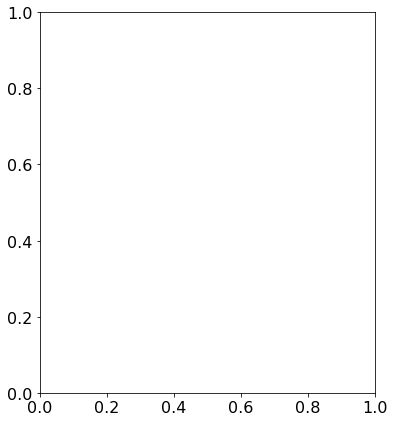

In [80]:
%%time
print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(6,7))

# Sort features by importance (descending order)
sorted_features = sorted(combined_importance.items(), key=lambda x: x[1], reverse=True)

# Extract sorted feature names and values
feature_names_sorted, feature_values_sorted = zip(*sorted_features)

# Plot sorted feature importances
plt.barh(range(len(feature_names_sorted)), feature_values_sorted, align='center', color="#4c72b0")
plt.yticks(range(len(feature_names_sorted)), feature_names_sorted)
plt.xlabel('SHAP Importance')
# plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Ensure the most important feature is at the top
plt.savefig('./output/feature_importance_shap.pdf', bbox_inches='tight')
# plt.show()

# shap_importance = shap_values.abs.mean(0).values
# sorted_idx = shap_importance.argsort()
# plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center',color="#4c72b0") #'turquoise'
# plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
# plt.xlabel('SHAP Importance')
# plt.savefig('./output/feature_importance_shap.pdf', bbox_inches='tight')

# PDP (Optional)
(may need to skip bc lightgbm seems not support PartialDependenceDisplay of categorical feature)

In [176]:
# feature_list_continuous= ['minutes_since_midnight','airbnb_count',
#                           'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 
#                           'distance_to_Shuttle_Expo_Center',  'distance_to_venue'
#                           ]
# print('number of continuous features:',len(feature_list_continuous))
# # feature_list_cat = []

In [177]:
# %%time 
# from sklearn.inspection import PartialDependenceDisplay
# # ~5min per PDP graph
# # using for loop, otherwise might occur memory errors
# # PDP for continuous features and save the graph for each feature separately
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# for feature_one in feature_list_continuous:
#     print(datetime.datetime.now(), feature_one)
#     plt.rcParams.update({'font.size': 14})
#     fig, ax = plt.subplots(figsize=(5,5))
#     pdp_one = PartialDependenceDisplay.from_estimator(model, X, [feature_one],n_jobs = 6, ax=ax)
#     plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")
# #     break
    
# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

In [178]:
# %%time
# # # PDP for categorical variable
# # fig, ax = plt.subplots(figsize=(10, 6))
# # PartialDependenceDisplay.from_estimator(model, X, ['road_type'], categorical_features=['road_type'], n_jobs=6, ax=ax)
# # plt.show()

# # plt.rcParams.update({'font.size': 14})
# # fig, ax = plt.subplots(figsize=(5,5))
# # PartialDependenceDisplay.from_estimator(model, X, ['road_type'], categorical_features=['road_type'], n_jobs=6, ax=ax)
# # pdp1 = PartialDependenceDisplay.from_estimator(model, X, [feature_one], n_jobs=6 , ax=ax)
# # plt.savefig('./output/pdp_'+feature_one+'.pdf',bbox_inches="tight")

# Optional further SHAP analysis

2024-12-13 12:09:42.617856 *************** Start running beeswarm ***************
CPU times: user 1min 31s, sys: 0 ns, total: 1min 31s
Wall time: 1min 29s


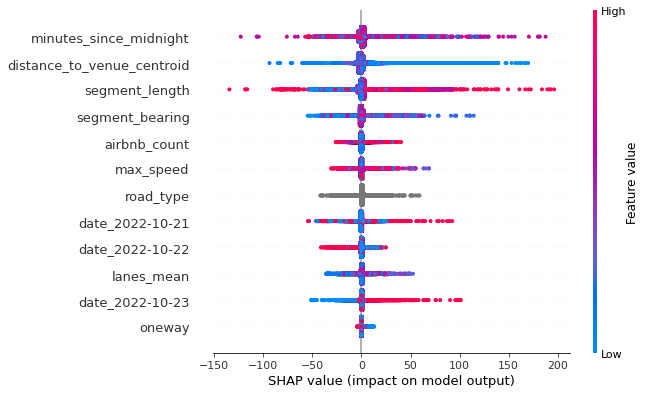

In [63]:
%%time
# ~6min
# Reading about gray colors: https://mlconference.ai/blog/tutorial-explainable-machine-learning-with-python-and-shap/
print(datetime.datetime.now(),'*************** Start running beeswarm ***************')
fig_beeswarm = shap.plots.beeswarm(shap_values,show=False, max_display=50)
plt.savefig('./output/shap_beeswarm.pdf', bbox_inches='tight')

In [64]:
X.columns

Index(['minutes_since_midnight', 'segment_length', 'segment_bearing', 'oneway', 'lanes_mean', 'road_type', 'max_speed', 'date_2022-10-21', 'date_2022-10-22', 'date_2022-10-23', 'airbnb_count', 'distance_to_venue_centroid'], dtype='object')

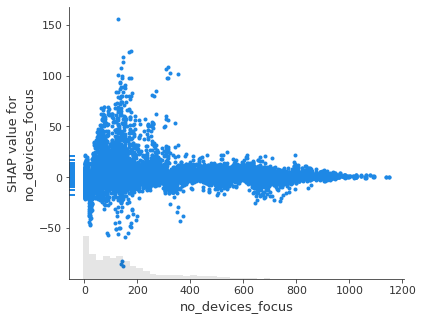

CPU times: user 1min 19s, sys: 196 ms, total: 1min 20s
Wall time: 1min 20s


In [39]:
%%time
shap.plots.scatter(shap_values[:, "no_devices_focus"])

In [ ]:
shap.dependence_plot('distance_to_venue_centroid', shap_values.values, X, dot_size=10, alpha=0.5,
                               interaction_index='no_devices_focus', show=False)

In [ ]:
# Documentation: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html
shap.plots.scatter(shap_values[:, "distance_to_venue_centroid"])  #check distance_to_venue_centroid

In [ ]:
# shap.plots.scatter(shap_values[:, "minutes_since_midnight"])
shap.dependence_plot('minutes_since_midnight', shap_values.values, X, dot_size=10, alpha=0.5,
                               interaction_index='distance_to_venue_centroid', show=False)

In [89]:
%%time
shap.plots.scatter(shap_values[:, "airbnb_count"])
# shap.dependence_plot('airbnb_count', shap_values.values, X, dot_size=10, alpha=0.5,
#                                interaction_index='distance_to_venue_centroid', show=False)

In [88]:
shap.plots.scatter(shap_values[:, "segment_bearing"])

In [87]:
shap.plots.scatter(shap_values[:, "segment_length"])

In [86]:
shap.plots.scatter(shap_values[:, "lanes_mean"])

In [85]:
shap.plots.scatter(shap_values[:, "max_speed"])

In [83]:
shap.dependence_plot('road_type', shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index='distance_to_venue_centroid', show=False, x_jitter=0.5)

In [126]:
# shap.plots.scatter(shap_values[:, "road_type"])

In [84]:
shap.dependence_plot('oneway', shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index='distance_to_venue_centroid', show=False, x_jitter=0.5)

## Spatial SHAP

In [75]:
df_shap_merged = df_traffic.merge(df_shape_values, ) #on=['tmc_code', 'minutes_since_midnight', 'date_2022-10-21','date_2022-10-22','date_2022-10-23']
print(df_shap_merged.shape[0])
df_shap_merged.head()

866449


,tmc_code,hour_min,delay_baseline,delay_focus,delay_difference,intersection,start_latitude,start_longitude,end_latitude,end_longitude,segment_length,airbnb_count,distance_to_venue_centroid,distance_to_Shuttle_Waterloo_Park,distance_to_Shuttle_Barton_Creek_Square,distance_to_Shuttle_Expo_Center,segment_bearing,osm_id,road_type,oneway,lanes,maxspeed,lanes_mean,minutes_since_midnight,date_2022-10-21,date_2022-10-22,date_2022-10-23,max_speed,shap_minutes_since_midnight,shap_segment_length,shap_segment_bearing,shap_oneway,shap_lanes_mean,shap_road_type,shap_max_speed,shap_date_2022-10-21,shap_date_2022-10-22,shap_date_2022-10-23,shap_airbnb_count,shap_distance_to_venue_centroid
0,112+04760,09:00,-1.30941,-0.54871,0.76071,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,"['1', '2']",55 mph,1.50000,540,1,0,0,55.00000,-0.21827,-0.96356,-0.45418,-0.01172,-0.09461,0.34925,0.33935,0.45318,0.08170,0.01048,-0.16211,-0.77516
1,112+04760,09:10,0.00000,-1.77926,-1.77926,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,"['1', '2']",55 mph,1.50000,550,1,0,0,55.00000,-0.16006,-0.45093,-0.28606,-0.03561,-0.00280,0.21872,0.33367,0.37435,0.05931,0.01031,0.07095,-0.60821
2,112+04760,09:20,-0.54871,-1.77926,-1.23055,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,"['1', '2']",55 mph,1.50000,560,1,0,0,55.00000,-0.30254,-0.28288,-0.21448,-0.03393,-0.11840,0.07802,0.36938,0.29424,0.04249,-0.00366,0.06425,-0.56602
3,112+04760,09:30,-1.77926,-1.77926,0.00000,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,"['1', '2']",55 mph,1.50000,570,1,0,0,55.00000,-0.56381,-0.11521,-0.14709,-0.08472,0.01748,0.03209,0.43572,0.17208,-0.06494,-0.01464,-0.01100,-0.41267
4,112+04760,09:40,-1.54784,0.00000,1.54784,US-183/EXIT 239-240,30.32874,-97.70568,30.33272,-97.70402,0.29287,49,26.64241,7.39988,14.41580,10.33789,19.79829,"[122981397, 1012363973]66847798019339769835",secondary,True,"['1', '2']",55 mph,1.50000,580,1,0,0,55.00000,-0.38371,-0.29069,0.05774,-0.05090,0.15939,0.08098,0.42084,0.10329,0.08977,-0.03089,-0.14186,-0.48977


In [76]:
print('average prediction:', df_shap_merged.shap_minutes_since_midnight.mean())

average prediction: -0.003870122198600434


In [77]:
# Create a polygon for event venue
from shapely.geometry import Polygon
import geopandas as gpd

lat_point_list = [30.131962, 30.146337, 30.140386, 30.122629]
lon_point_list = [-97.647388, -97.635686, -97.619652, -97.631465]
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       
polygon['name']  = 'the Circuit of the Americas'
polygon
# polygon.explore()

import shapely.geometry as geom

# Create Shapely point geometries
point_waterloo_park = geom.Point(-97.736285, 30.273726) # (longitude, latitude)
point_barton_creek_square = geom.Point(-97.805046, 30.257509)
point_expo_center = geom.Point(-97.622544, 30.297062)
point_ridehailing = geom.Point(-97.614135, 30.178718)

point_shuttle_list = [point_waterloo_park,point_barton_creek_square,point_expo_center,point_ridehailing]
gdf_shuttle = gpd.GeoDataFrame({'Shuttle_Location': ['Shuttle_Waterloo_Park', 'Shuttle_Barton_Creek_Square', 'Shuttle_Expo_Center', 'Uber_DelValle_HighSchool'],
                        'geometry': point_shuttle_list},
                        crs="EPSG:4326")
# gdf_shuttle

In [78]:
df_road = pd.read_csv("data/TMC_Identification.csv", sep=',', header=0)
df_road = df_road[['tmc_code','intersection','start_latitude','start_longitude','end_latitude','end_longitude','miles']]

from shapely.geometry import LineString
from geopandas import GeoDataFrame

df_road['geometry'] = df_road.apply(
    lambda row: LineString([(row['start_longitude'], row['start_latitude']),
                             (row['end_longitude'], row['end_latitude'])]),
    axis=1
)

# Create a GeoDataFrame
gdf_road = GeoDataFrame(df_road, geometry='geometry',crs="EPSG:4326")
print(gdf_road.shape[0])

4460


In [109]:
# Select one time point and plot the SHAP values of several features at that specfic time point
# hourmin_select, date_select = 600, 'date_2022-10-22' #1200
hourmin_select, date_select = 1200, 'date_2022-10-22' #1200
df_plotshap = df_shap_merged[(df_shap_merged['minutes_since_midnight'] == hourmin_select)&(df_shap_merged[date_select] == 1)]
# df_plotshap['shap_coordinates'] = df_plotshap['shap_start_latitude'] + df_plotshap['shap_start_longitude']
print(df_plotshap.shape[0])
print(gdf_road.shape[0])

gdf_road_merged = gdf_road.merge(df_plotshap,) #left_on='tmc', right_on='tmc_code'
print(gdf_road_merged.shape[0])
# gdf_road_merged.shap_coordinates.describe()

3221
4460
3098


In [110]:
gdf_road_merged.columns

Index(['tmc_code', 'intersection', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'miles', 'geometry', 'hour_min', 'delay_baseline', 'delay_focus', 'delay_difference', 'segment_length', 'airbnb_count', 'distance_to_venue_centroid', 'distance_to_Shuttle_Waterloo_Park', 'distance_to_Shuttle_Barton_Creek_Square', 'distance_to_Shuttle_Expo_Center', 'segment_bearing', 'osm_id', 'road_type', 'oneway', 'lanes', 'maxspeed', 'lanes_mean', 'minutes_since_midnight', 'date_2022-10-21', 'date_2022-10-22', 'date_2022-10-23', 'max_speed', 'shap_minutes_since_midnight', 'shap_segment_length', 'shap_segment_bearing', 'shap_oneway', 'shap_lanes_mean', 'shap_road_type', 'shap_max_speed', 'shap_date_2022-10-21', 'shap_date_2022-10-22', 'shap_date_2022-10-23', 'shap_airbnb_count', 'shap_distance_to_venue_centroid'], dtype='object')

In [90]:
%%time
# 'shap_minutes_since_midnight', 'shap_segment_length', 'shap_segment_bearing', 'shap_oneway', 'shap_lanes_mean', 'shap_road_type', 
# 'shap_max_speed', 'shap_date_2022-10-21', 'shap_date_2022-10-22', 'shap_date_2022-10-23', 'shap_airbnb_count', 'shap_distance_to_venue_centroid'
# congestion_colors = ["#00FF00", "#ADFF2F", "#FFFF00", "#FFA500", "#FF0000", "#8B0000"]
shap_select = 'shap_oneway'
print('date:', date_select)
print('hour',hourmin_select/60)
print(shap_select)
m = gdf_road_merged.explore(
    column=shap_select,
    cmap= 'rainbow',
    tiles="CartoDB Positron", # OpenStreetMap, CartoDB dark_matter, CartoDB Positron
    categorical=False
)

m = gdf_shuttle.explore(
    m=m,
    markersize=40,
    linewidth=2,
    edgecolor="black",
)

polygon.explore(
    m=m
)